# Active Subspace Uncertainty Quantification for an Annular Combustor

##### M. Bauerheim, CERFACS, CFD team, <bauerheim@cerfacs.fr>
##### A. Ndiaye, CERFACS, CFD team
##### P. Constantine, Colorado School of Mines, <pconstan@mines.edu>
##### S. Moreau, Sherbrooke University
##### S. Nicoud, Université de Montpellier
##### Ryan Howard, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces-based uncertainty quantification on an asymmetric thermoacoustic model, presented in [[1]][R1].

### Introduction

Symmetries play an important role in dscribing many physical phenomena, and breaking symmetries can cause various unusual or undesirable behaviors such as instability, splitting, and chaos. Breaking rotational symmetries (as found in pipes and annular cavities, for example) can cause instabilities in circumfrential/azimuthal modes, which can cause problems for the design of physical aparatus. For example, azimuthal thermoacoustic instabilities in an annular combustor can couple with unsteady heat release and cause vibrations and structural damage.

This study will examine an annular combustion chamber and annular plenum connected by 19 burners. If it were perfectly symmetric, the modes would all be stable; we'll be studying the uncertainty introduced by random tolerances on burner characteristics that break the cylindrical symmetry of the setup. The quantities we treat as uncertain are the gain and time delay of each of the burners, which totals 38 (19\*2) uncertain parameters. 

Parameter studies in more than a few dimensions tend to be very costly; the model evaluations required to sample the paramter space tends to increase exponentially with dimension. Because of this, we reduce the dimensionality of our problem by using _active subspaces_ methodology, which looks for important directions in the input space along which changes in output are more pronounced than in the orthogonal directions.

### The Thermoacoustic Model

The geometry described in the introduction (an annular chamber and an annular plenum connected by 19 burners) is given to the ATACAMAC (analytical tool to analyse and control azimuthal mode in annular chambers) tool, which solves the thermoacoustic problem and outputs the thermoacoustic modes and their stability. Each burner is modeled by a flame transfer function (FTF) that requires an amplitude and time delay ($n_i$ and $\tau_i$ for the $i^{th}$ burner, respectively), which are also inputs to the ATACAMAC simulation. Modes can be weakly coupled in the plenum, weakly coupled in the chamber, or strongly coupled. We study weakly coupled modes in the chamber and strongly coupled modes. For uncertainty quantification, we treat the FTF amplitudes and time delays as random quantities, summarized in the tables below.

*Weak coupling:*

Variable | Symbols | Mean | Std dev | Density
--- | --- | --- | --- | ---
FTF amplitudes (one for each burner) | $n_1 - n_{19}$ | 0.5 | 0.0433 | Gaussian
FTF time delays (one for each burner) | $\tau_1 - \tau_{19}$ | 0.000635 | 2.75e-5 | Gaussian

*Strong coupling:*

Variable| Symbols | Mean | Std dev | Density
--- | --- | --- | --- | ---
FTF amplitudes (one for each burner) | $n_1 - n_{19}$ | 1.75 | 0.1516 | Gaussian
FTF time delays (one for each burner) | $\tau_1 - \tau_{19}$ | 0.000735 | 3.18e-5 | Gaussian

The output of the model we are interested in is the growth rate of the first thermoacoustic mode, which is the imaginary part of the complex frequency, denoted $f_{Im}$. $f_{Im} > 0$ implies stability of the mode and $f_{Im} < 0$ implies instability.

### Uncertainty Quantification Using Active Subspaces

The forward uncertainty propagation problem in our case is to approximate the probability density function of $f_{Im}$ ($\text{PDF}(f_{Im})$) given the distributions of $\{n_i\}$ and $\{\tau_i\}$. We are interested in the risk factor (the probability that the mode is unstable, which happens if $f_{Im} > 0$):

$$
\text{RF(%)} = 100\int_0^\infty\text{PDF}(f_{Im})\ df_{Im}.
$$

Approximating the PDF (and thus the risk factor) could be done using Monte Carlo: sample the input space randomly, run the simulation, and use the resulting $f_{Im}$ values to construct the PDF. This converges at the same rate in any dimension, but it converges so slowly that it could be prohibitively expensive if the simulation is expensive. We will use _active subspaces_ to reduce the dimensionality of our problem, which makes methods like surrogate modeling possible where they would be infeasible in the full 38-dimensional input space.

The active subspace methodology is based on the matrix

$$
\mathbf C = \int\nabla f_{Im}\ \nabla f_{Im}^T\ \rho\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\nabla f_{Im}$ is the gradient of $f_{Im}$ with respect to the inputs ($\{(n_i,\tau_i)\}$), $\rho$ is the pdf of the inputs, and $\mathbf x$ represents the inputs as a vector. $\mathbf W\Lambda\mathbf W^T$ is the eigendecomosition of $\mathbf C$; $\Lambda$ contains the eigenvalues in descending order and $\mathbf W$ the corresponding eigenvectors. We can approximate this with simple Monte Carlo: draw $\{\mathbf x_k\}_{k=1}^M$ from $\rho$, then

$$
\mathbf C\approx \frac 1 M \sum_{k=1}^M\nabla f_{Im}(\mathbf x_k)\nabla f_{Im}(\mathbf x_k)^T.
$$

The $i^{th}$ eigenvalue quantifies how much $f_{Im}$ changes, on average, in the direction in the input space defined by the $i^{th}$ eigenvector; if the first few eigenvalues are large compared to the rest, we can examine $f_{Im}$ in the space defined by the span of the first few eigenvectors since it is likely to be relatively flat in the orthogonal directions.

### References:

[[1]][R1] Symmetry breaking of azimuthal thermoacoustic modes: the UQ perspective, _Journal of Fluid Mechanics_

[[2]][R2] Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces, _Siam Journal of Scientific Computing_

[R1]: http://dx.doi.org/10.1017/jfm.2015.730
[R2]: http://dx.doi.org/10.1137/130916138

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
import matplotlib.pyplot as plt
%matplotlib inline

Import the data set. Distinguish inputs (X), outputs (F), and gradients (G).

In [2]:
#Data Frames for each case
df_weak = pn.DataFrame.from_csv('atacamac-weak.txt')
df_strong = pn.DataFrame.from_csv('atacamac-strong.txt')

#Data matrices
data_weak = df_weak.as_matrix()
data_strong = df_strong.as_matrix()

#Inputs as row vectors (X), outputs as a column vector (f), and gradients as row vectors (G)
X_W = data_weak[:,:38]
f_W = data_weak[:,38]
G_W = data_weak[:,39:]

X_S = data_strong[:,:38]
f_S = data_strong[:,38]
G_S = data_strong[:,39:]

#How many data points we have (M) and the dimension of the input space (m)
M_W = X_W.shape[0]
M_S = X_S.shape[0]
m = X_W.shape[1]

#Labels for variables
labels = df_weak.keys()
in_labels = labels[:38]
out_labels = ['Weak Case', 'Strong Case']

Normalize the inputs to standard normal. 

In [3]:
#means for each case
n_mean_W = 0.5; tau_mean_W = 0.000635 # weakly coupled
n_mean_S = 1.75; tau_mean_S = 0.000735 # strongly coupled

#Create mean vector and covariance matrix
xmean_W = np.hstack((n_mean_W*np.ones((1, 19)), tau_mean_W*np.ones((1, 19))))
xstd_W = np.diagflat(np.hstack((n_mean_W*0.05*np.sqrt(3)*np.ones((1, 19)),
                             tau_mean_W*0.025*np.sqrt(3)*np.ones((1, 19)))))

#Normalize the inputs like (x-mu)/sigma
XX_W = ac.utils.misc.UnboundedNormalizer(xmean_W, xstd_W**2).normalize(X_W)

#Repeat for the strongly coupled case
xmean_S = np.hstack((n_mean_S*np.ones((1, 19)), tau_mean_S*np.ones((1, 19))))
xstd_S = np.diagflat(np.hstack((n_mean_S*0.05*np.sqrt(3)*np.ones((1, 19)),
                             tau_mean_S*0.025*np.sqrt(3)*np.ones((1, 19)))))
XX_S = ac.utils.misc.UnboundedNormalizer(xmean_S, xstd_S**2).normalize(X_S)

Compute the active subspace.

In [4]:
#subspace objects for the weak (ss_W) and strong (ss_S) cases
ss_W, ss_S = ac.subspaces.Subspaces(), ac.subspaces.Subspaces()

#compute the matrix C and its decomposition
ss_W.compute(df=G_W, nboot=500)
ss_S.compute(df=G_S, nboot=500)

Plot eigenvalues and subspace errors.

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


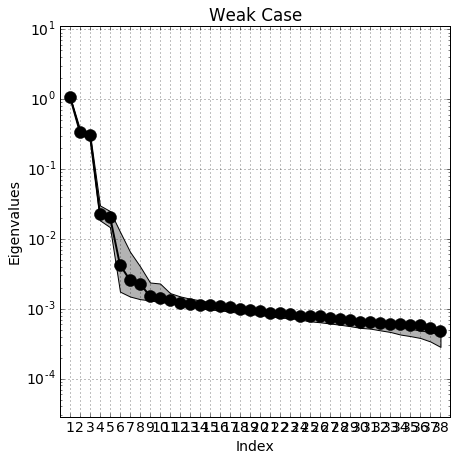

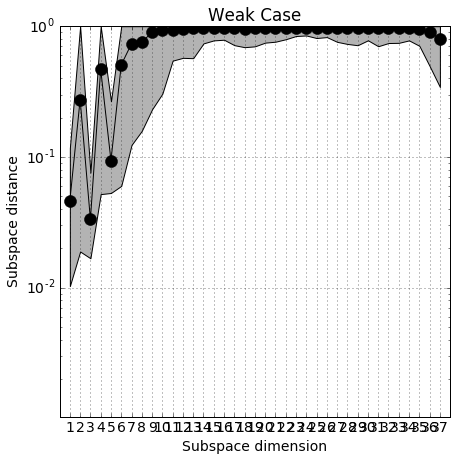

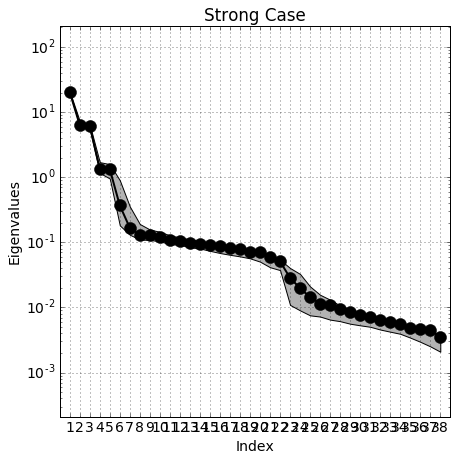

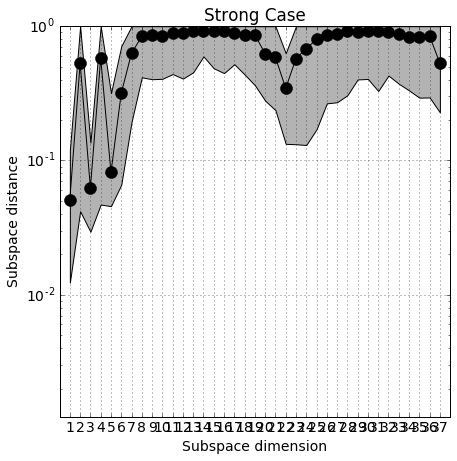

In [5]:
ss = [ss_W, ss_S]

for i in range(2):
    ac.utils.plotters.eigenvalues(ss[i].eigenvalues, ss[i].e_br, out_labels[i])
    ac.utils.plotters.subspace_errors(ss[i].sub_br, out_labels[i])

Large gaps in eigenvalues indicate active subspaces. Based on the eigenvalues and subspace distance, we expect 1, 3, or 5-dimensional subspaces in both the weak and strong cases. We'll now plot the first few eigenvectors to see what seems to affect stability the most (a large eigenvector component indicates relative sensitivity to the corresponding variable).

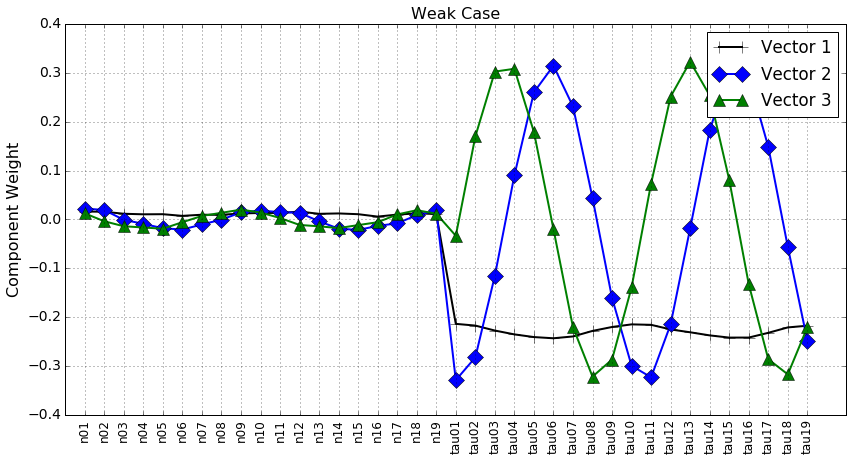

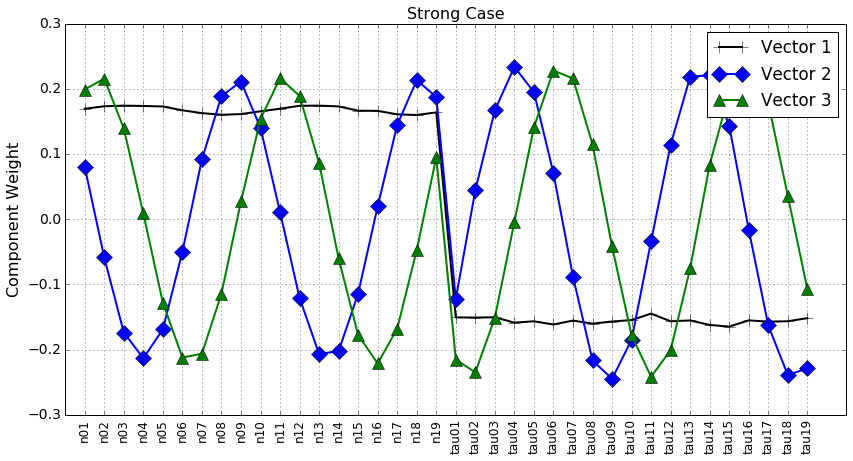

In [6]:
for i in range(2):
    plt.figure(figsize=(14,7))
    plt.plot(np.arange(1,39), ss[i].eigenvectors[:,0], 'k+-',
            np.arange(1,39), ss[i].eigenvectors[:,1], 'bD-',
            np.arange(1,39), ss[i].eigenvectors[:,2], 'g^-', ms=12, lw=2)
    plt.grid(True)
    plt.title(out_labels[i], fontsize=16)
    plt.ylabel('Component Weight', fontsize=16)
    plt.xticks(np.arange(1,39), in_labels, rotation='vertical', fontsize=12)
    plt.legend(['Vector 1', 'Vector 2', 'Vector 3'])

There is an interesting divergence between the two cases. In the weak case, almost all of the wieght is placed on the time delays; the amplitudes barely matter. In the strong case, both amplitudes and delays are heavily weighted for all three eigenvectors.

The sinusoidal nature and period of the eigenvectors and the underlying thermoacoustic theory suggests a change of variables that could improve the accuracy of the subspace:

$$
(n_i,\tau_i)\rightarrow (\Re(n_ie^{j\omega^0\tau_i}),\Im(n_ie^{j\omega^0\tau_i})) = (n_i\cos(\omega^0\tau_i), n_i\sin(\omega^0\tau_i)),
$$

where $\omega^0$ is a constant related to some physical parameters of the system. See [[1]][R1] for more details on this change of variables. We'll go through the change and demonstrate its effects now.

[R1]: http://dx.doi.org/10.1017/jfm.2015.730

In [7]:
omega0 = np.pi*832/.54

#new coordinates and new gradients
X_W_prime = np.empty_like(X_W, dtype='float64')
X_S_prime = np.empty_like(X_S, dtype='float64')
G_W_prime = np.empty_like(G_W, dtype='float64')
G_S_prime = np.empty_like(G_S, dtype='float64')

#Create new coordinates and gradients by pair (n_i, tau_i), of which there are 19
for i in range(19):
    F = X_W[:,i]*np.exp(1j*omega0*X_W[:,19+i]); n = F.real; tau = F.imag
    X_W_prime[:,i] = n; X_W_prime[:,19+i] = tau
    
    #Gradients must be calculated based on change-of-variables formulae/chain rules, e.g. 
    #df/dn' = df/dn dn/dn' + df/dtau dtau/dn'
    G_W_prime[:,i] = G_W[:,i]/(n_mean_W*0.05*np.sqrt(3))*np.sqrt(1 + (tau/n)**2)**-1 - \
        G_W[:,19+i]/(tau_mean_W*0.025*np.sqrt(3))*tau*(omega0*(tau**2 + n**2))**-1
    G_W_prime[:,19+i] = G_W[:,19+i]/(tau_mean_W*0.025*np.sqrt(3))*n*(omega0*(tau**2 + \
        n**2))**-1 + G_W[:,i]/(n_mean_W*0.05*np.sqrt(3))*tau/np.sqrt(tau**2 + n**2)
    
    #Repeat for the strong case
    F = X_S[:,i]*np.exp(1j*omega0*X_S[:,19+i]); n = F.real; tau = F.imag
    X_S_prime[:,i] = n; X_S_prime[:,19+i] = tau
    
    G_S_prime[:,i] = G_S[:,i]/(n_mean_S*0.05*np.sqrt(3))*np.sqrt(1 + (tau/n)**2)**-1 - \
        G_S[:,19+i]/(tau_mean_S*0.025*np.sqrt(3))*tau*(omega0*(tau**2 + n**2))**-1
    G_S_prime[:,19+i] = G_S[:,19+i]/(tau_mean_S*0.025*np.sqrt(3))*n*(omega0*(tau**2 + \
        n**2))**-1 + G_S[:,i]/(n_mean_S*0.05*np.sqrt(3))*tau/np.sqrt(tau**2 + n**2)

    
#Normalize new coordinates using empirical means/standard deviations like (x-mu)/sigma
XX_W_prime = (X_W_prime - X_W_prime.mean(0).reshape(1, X_W_prime.shape[1]))/\
    X_W_prime.std(0, ddof=1).reshape(1, X_W_prime.shape[1])
    
XX_S_prime = (X_S_prime - X_S_prime.mean(0).reshape(1, X_S_prime.shape[1]))/\
    X_S_prime.std(0, ddof=1).reshape(1, X_S_prime.shape[1])

#Gradients wrt normalized new inputs
G_W_prime = G_W_prime*X_W_prime.std(0, ddof=1).reshape(1, X_W_prime.shape[1])
G_S_prime = G_S_prime*X_S_prime.std(0, ddof=1).reshape(1, X_S_prime.shape[1])

#New subspace objects
ss_W_prime = ac.subspaces.Subspaces()
ss_W_prime.compute(df=G_W_prime, nboot=500)
ss_S_prime = ac.subspaces.Subspaces()
ss_S_prime.compute(df=G_S_prime, nboot=500)

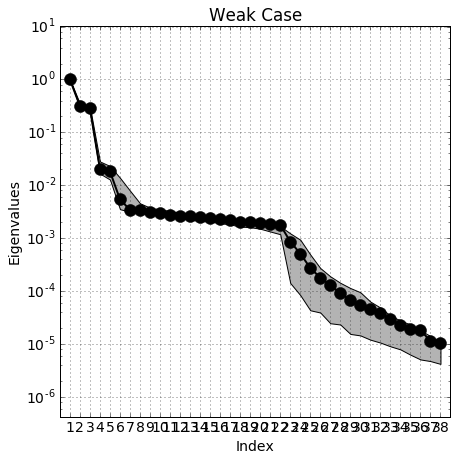

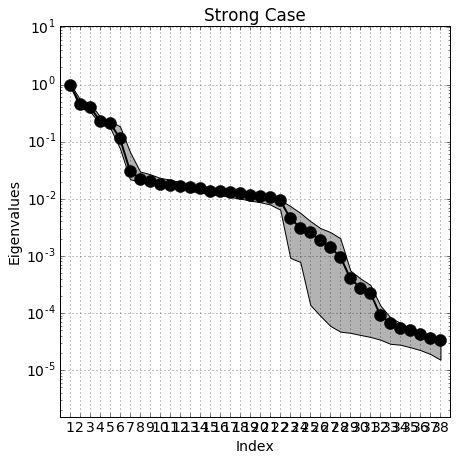

<Container object of 3 artists>

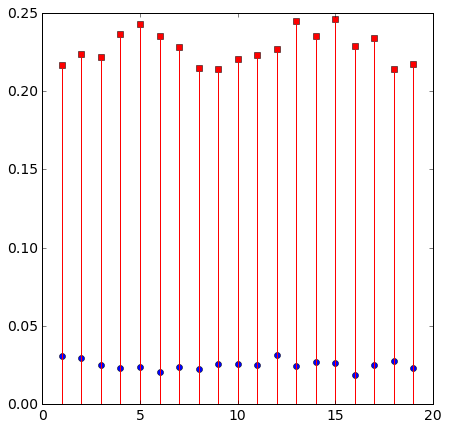

In [8]:
#Plot normalized eigenvalues for each case
ac.utils.plotters.eigenvalues(ss_W_prime.eigenvalues/ss_W_prime.eigenvalues[0], 
                             ss_W_prime.e_br/ss_W_prime.eigenvalues[0], out_labels[0])
ac.utils.plotters.eigenvalues(ss_S_prime.eigenvalues/ss_S_prime.eigenvalues[0], 
                             ss_S_prime.e_br/ss_S_prime.eigenvalues[0], out_labels[1])


#Make a stem plot of the first eigenvector
plt.figure(figsize=(7,7))
plt.stem(np.arange(1,20), ss_W_prime.eigenvectors[:19,0])
plt.stem(np.arange(1,20), ss_W_prime.eigenvectors[19:,0], 'r-', 'rs')

Now that we've separated the input space into an active subspace along which $f_{Im}$ tends to change a lot and an inactive subspace along which $f_{Im}$ is relatively flat, one might ask how to exploit this finding. One approach is surrogate modeling using polynomial response surfaces. This method suffers the curse of dimensionality; the number of parameters (monomial coefficients in this case) to be fit grows rapidly with dimension, so reducing the dimension can allow one to fit higher-order polynomials with the same amount of data. For example, we have enough data to fit a linear model on the full input space, but not enough for quadratic or higher-order models. By performing this analysis on the active subspace (only 3-dimensional), we do have enough data to fit quadratic and cubic models. We now construct a linear model on the full space and linear, quadratic, and cubic models on the reduced space for the weak and strong cases, and compare their performance.

In [9]:
#Response surface/surrogate model objects
FL_W = ac.utils.response_surfaces.PolynomialApproximation(1) #FL = Full Linear
RL_W = ac.utils.response_surfaces.PolynomialApproximation(1) #RL = Reduced Linear
RQ_W = ac.utils.response_surfaces.PolynomialApproximation(2) #RQ = Reduced Quadratic
RC_W = ac.utils.response_surfaces.PolynomialApproximation(3) #RC = Reduced Cubic

FL_S = ac.utils.response_surfaces.PolynomialApproximation(1)
RL_S = ac.utils.response_surfaces.PolynomialApproximation(1)
RQ_S = ac.utils.response_surfaces.PolynomialApproximation(2)
RC_S = ac.utils.response_surfaces.PolynomialApproximation(3)

#Normalize new coordinates using empirical means/standard deviations like (x-mu)/sigma
XX_W_prime = (X_W_prime - X_W_prime.mean(0).reshape(1, X_W_prime.shape[1]))/\
    X_W_prime.std(0, ddof=1).reshape(1, X_W_prime.shape[1])
    
XX_S_prime = (X_S_prime - X_S_prime.mean(0).reshape(1, X_S_prime.shape[1]))/\
    X_S_prime.std(0, ddof=1).reshape(1, X_S_prime.shape[1])

#Train response surfaces with data
ss_W_prime.partition(3)
ss_S_prime.partition(3)

RS_W = [FL_W, RL_W, RQ_W, RC_W]
RS_S = [FL_S, RL_S, RQ_S, RC_S]

RS_W[0].train(XX_W_prime, f_W[:,None])
RS_S[0].train(XX_S_prime, f_S[:,None])

for i in range(1, 4):
    RS_W[i].train(XX_W_prime.dot(ss_W_prime.W1), f_W[:,None])
    RS_S[i].train(XX_S_prime.dot(ss_S_prime.W1), f_S[:,None])

R^2 values for response surfaces:
                       Weak Case     Strong case  
Full Linear         :      0.809           0.583     
Reduced Linear      :      0.789           0.536     
Reduced Quadratic   :      0.964           0.546     
Reduced Cubic       :      0.964           0.589     


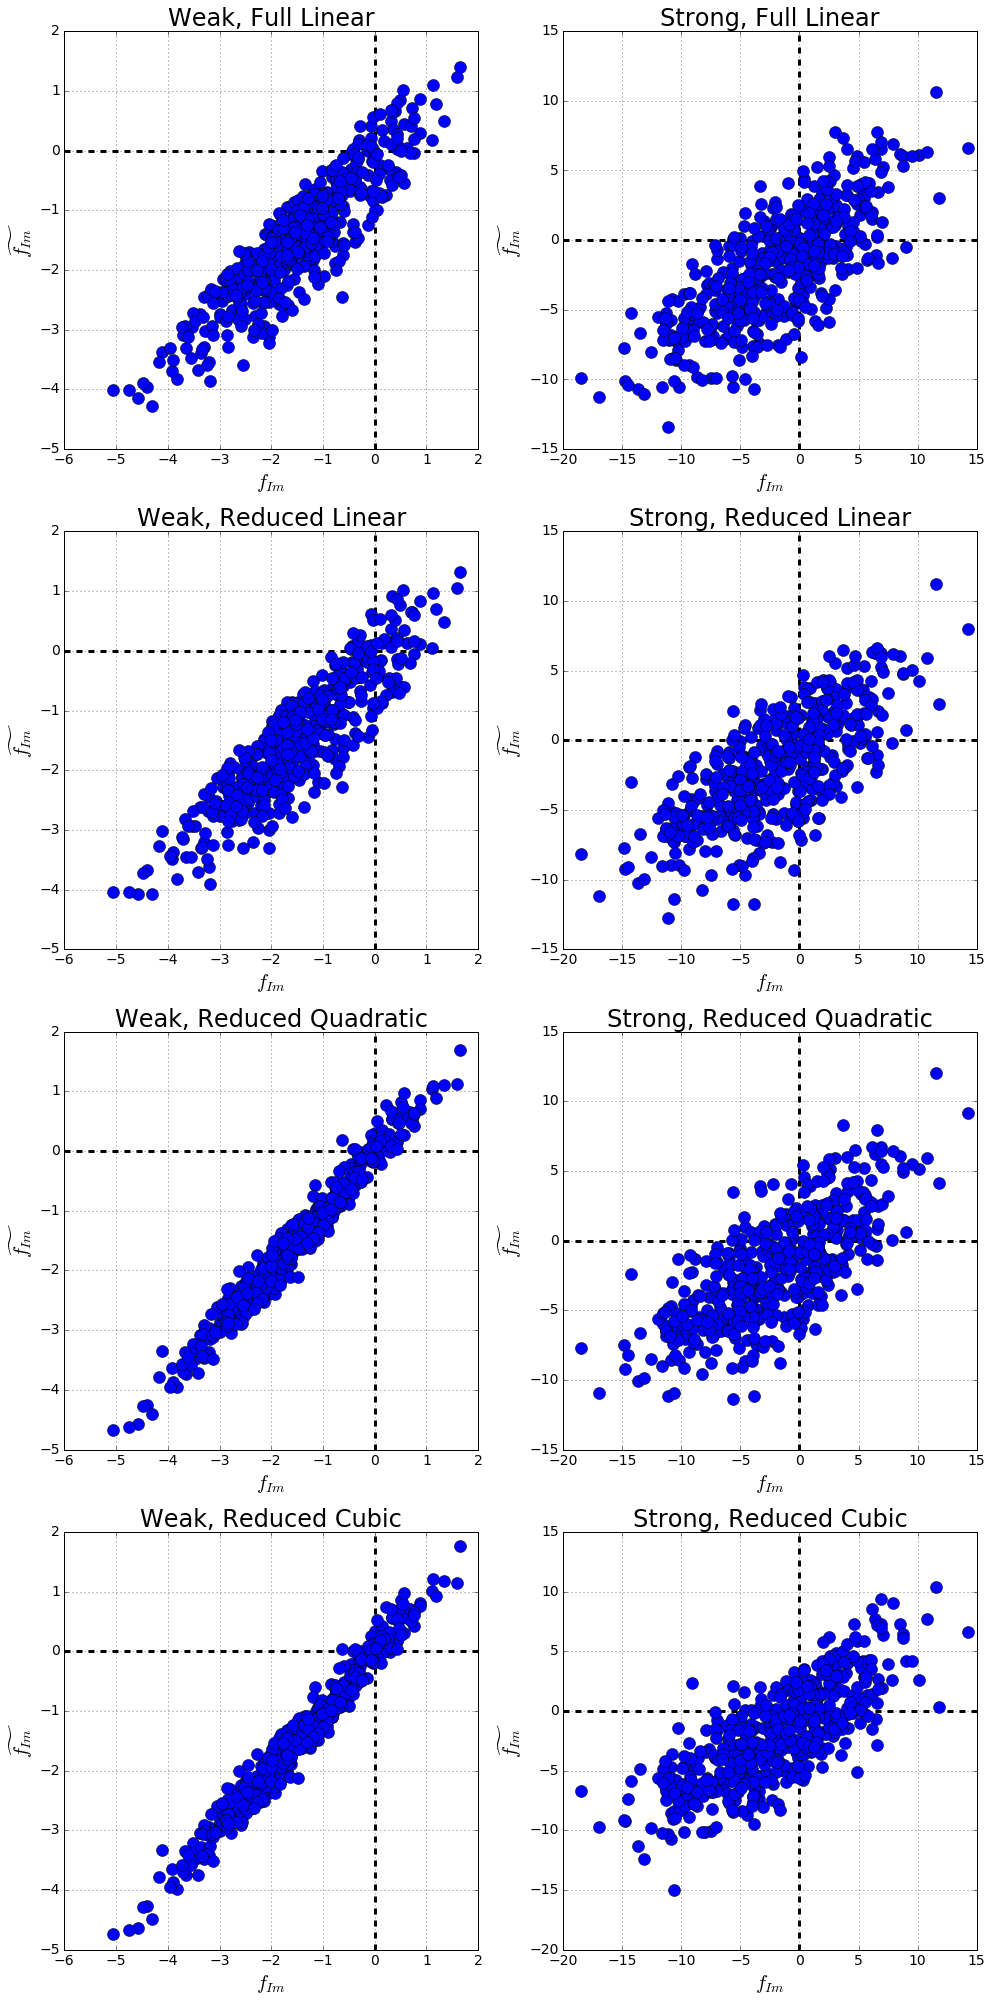

In [39]:
print 'R^2 values for response surfaces:'
print '{:20}{:^15}{:^15}'.format('', 'Weak Case', 'Strong case')
L = ['Full Linear', 'Reduced Linear', 'Reduced Quadratic', 'Reduced Cubic']
for i in range(4):
    print '{:20}: {:^15.3} {:^15.3}'.format(L[i], RS_W[i].Rsqr, RS_S[i].Rsqr)


fig, axes = plt.subplots(4, 2, figsize=(2*7, 4*7)); axes = axes.reshape(8)
XX = [XX_W_prime, XX_S_prime]
ss = [ss_W_prime, ss_S_prime]
f = [f_W, f_S]
RS = [RS_W, RS_S]
L0 =['Weak', 'Strong']
for i in range(8):
    y = XX[i%2] if i in [0, 1] else XX[i%2].dot(ss[i%2].W1)
    axes[i].plot(f[i%2], RS[i%2][i/2].predict(y)[0], 'bo', markersize=12)
    axes[i].vlines(0, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                   linestyles='dashed', linewidth=3)
    axes[i].hlines(0, axes[i].get_xlim()[0], axes[i].get_xlim()[1],
                   linestyles='dashed', linewidth=3)
    axes[i].grid(True)
    axes[i].set_xlabel(r'$f_{Im}$', fontsize=20)
    axes[i].set_ylabel(r'$\widetilde{f_{Im}}$', fontsize=20)
    axes[i].set_title('{}, {}'.format(L0[i%2], L[i/2]), fontsize=24)
fig.tight_layout()

From the $R^2$ values and the plots of estimated values $\widetilde{f_{Im}}$ vs actual values $f_{Im}$, we can see especially for the weak case that using active subspaces can help our prediction; the $R^2$ value increases from .809 for the full linear model to .964 for the reduced quadratic and cubic models with noticably better fit in the plots. The strong case is different in that only the reduced cubic model does better than the full linear model and the fit is not nearly as good in any model compared to the weak case. The dashed lines separate the graphs into 4 regions. The lower-left and upper-right regions represent correct predictions (of stability and instability, respectively) while the upper-left and lower-right regions represent incorrect predictions; ideally no points would lie in the upper-left or lower-right regions.

Now that we have inexpensive surrogate models, we can approximate the risk factor for each case using Monte Carlo. We draw many samples from the pdf of $\{(n_i,\tau_i)\}$, change variables, normalize, approximate $f_{Im}$ with the response surfaces, and use these to approximate the PDF of $f_{Im}$ and the risk factor (an integral of the PDF). This does not require any expensive enw simulations, only evaluations of our response surfaces.

In [45]:
N = 50000 #Number of replicates to use.

#means for each case
n_mean_W = 0.5; tau_mean_W = 0.000635 # weakly coupled
n_mean_S = 1.75; tau_mean_S = 0.000735 # strongly coupled

#Create mean vector and covariance matrix
xmean_W = np.hstack((n_mean_W*np.ones((1, 19)), tau_mean_W*np.ones((1, 19)))).squeeze()
xstd_W = np.diagflat(np.hstack((n_mean_W*0.05*np.sqrt(3)*np.ones((1, 19)),
                             tau_mean_W*0.025*np.sqrt(3)*np.ones((1, 19)))))

#Repeat for the strongly coupled case
xmean_S = np.hstack((n_mean_S*np.ones((1, 19)), tau_mean_S*np.ones((1, 19)))).squeeze()
xstd_S = np.diagflat(np.hstack((n_mean_S*0.05*np.sqrt(3)*np.ones((1, 19)),
                             tau_mean_S*0.025*np.sqrt(3)*np.ones((1, 19)))))

#Generate unnormalized replicates
X_W_MC = np.random.multivariate_normal(xmean_W, xstd_W**2, N)
X_S_MC = np.random.multivariate_normal(xmean_S, xstd_S**2, N)

#Change variables
X_W_prime_MC = np.empty_like(X_W_MC)
X_S_prime_MC = np.empty_like(X_S_MC)
for i in range(19):
    F = X_W_MC[:,i]*np.exp(1j*omega0*X_W_MC[:,19+i]); n = F.real; tau = F.imag
    X_W_prime_MC[:,i] = n; X_W_prime_MC[:,19+i] = tau
    
    F = X_S_MC[:,i]*np.exp(1j*omega0*X_S_MC[:,19+i]); n = F.real; tau = F.imag
    X_S_prime_MC[:,i] = n; X_S_prime_MC[:,19+i] = tau
    
#normalize new variables
XX_W_prime_MC = (X_W_prime_MC - X_W_prime.mean(0).reshape(1, X_W_prime.shape[1]))/\
    X_W_prime.std(0, ddof=1).reshape(1, X_W_prime.shape[1])
    
XX_S_prime_MC = (X_S_prime_MC - X_S_prime.mean(0).reshape(1, X_S_prime.shape[1]))/\
    X_S_prime.std(0, ddof=1).reshape(1, X_S_prime.shape[1])
    
#calculate f_{Im}
ftilde_W = RC_W.predict(XX_W_prime_MC.dot(ss_W_prime.W1))[0]
ftilde_S = RC_S.predict(XX_S_prime_MC.dot(ss_S_prime.W1))[0]

The weak case has risk factor 9.712% and
the strong case has risk factor 26.95%.


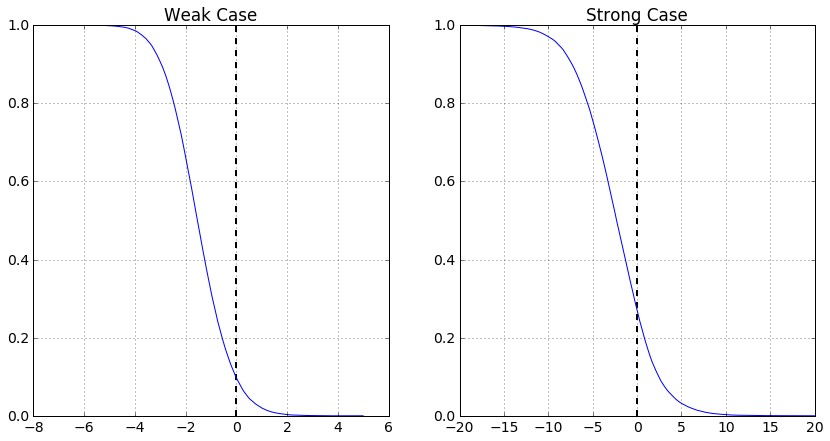

In [53]:
RF_W = 1.*len(ftilde_W[ftilde_W > 0])/len(ftilde_W)
RF_S = 1.*len(ftilde_S[ftilde_S > 0])/len(ftilde_S)

print 'The weak case has risk factor {:.4}% and'.format(100*RF_W)
print 'the strong case has risk factor {:.4}%.'.format(100*RF_S)

x_W = np.linspace(-7, 5, 200)
x_S = np.linspace(-20, 20, 200)

#Cumulative distribution functions (cdf's)
cdf_W = np.vectorize(lambda x: 1.*len(ftilde_W[ftilde_W <= x])/len(ftilde_W))
cdf_S = np.vectorize(lambda x: 1.*len(ftilde_S[ftilde_S <= x])/len(ftilde_S))

#plot cdf's
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(x_W, 1 - cdf_W(x_W))
plt.vlines(0, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', linewidth=2)
plt.grid(True)
plt.title('Weak Case')

plt.subplot(1, 2, 2)
plt.plot(x_S, 1 - cdf_S(x_S))
plt.vlines(0, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', linewidth=2)
plt.grid(True)
plt.title('Strong Case')